In [1]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs


def bokeh_plotter(data_list, x_axis_list=None, label_list=None,
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):

        color = next(color_cycle)

        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception(
                'problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i + 1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)


def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return

    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')


def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1,
                             speed_profile=True):
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values

    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x'] ** 2 + df['speed_y'] ** 2) ** 0.5

    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold

    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1, fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[
                          0] - 1  # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]

    saccade_dict = {'saccade_start_ind': saccade_on_inds,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind': saccade_off_inds,
                    'saccade_end_timestamp': saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}

    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)

    distances = []
    angles = []
    speed_list = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) &
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            speed_list.append(saccade_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                                   endpoint['center_x'] - initial_position['center_x'])

        angles.append(overall_angle)
        distances.append(distance_traveled)

    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(
        angles) % 360)  # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df[
        'initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df[
        'initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)

    return df, saccade_events_df


# create a multi-animal block_collection:

def create_block_collections(animals, block_lists, experiment_path, bad_blocks=None):
    """
    Create block collections and a block dictionary from multiple animals and their respective block lists.

    Parameters:
    - animals: list of str, names of the animals.
    - block_lists: list of lists of int, block numbers corresponding to each animal.
    - experiment_path: pathlib.Path, path to the experiment directory.
    - bad_blocks: list of int, blocks to exclude. Default is an empty list.

    Returns:
    - block_collection: list of BlockSync objects for all specified blocks.
    - block_dict: dictionary where keys are block numbers as strings and values are BlockSync objects.
    """
    import UtilityFunctions_newOE as uf

    if bad_blocks is None:
        bad_blocks = []

    block_collection = []
    block_dict = {}

    for animal, blocks in zip(animals, block_lists):
        # Generate blocks for the current animal
        current_blocks = uf.block_generator(
            block_numbers=blocks,
            experiment_path=experiment_path,
            animal=animal,
            bad_blocks=bad_blocks
        )
        # Add to collection and dictionary
        block_collection.extend(current_blocks)
        for b in current_blocks:
            block_dict[f"{animal}_block_{b.block_num}"] = b

    return block_collection, block_dict


In [2]:
# Example usage:
# This was the previous run
#animals = ['PV_62', 'PV_126', 'PV_57']
#block_lists = [[24, 26, 38], [7, 8, 9, 10, 11, 12], [7, 8, 9, 12, 13]]
#This with new animals:
animals = ['PV_106','PV_143','PV_62','PV_126', 'PV_57']
block_lists = [[8,9,10,11,12],[1,2,3,4],[24, 26, 38],[7, 8, 9, 10, 11, 12], [7, 8, 9, 12, 13]]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
bad_blocks = [0]  # Example of bad blocks

block_collection, block_dict = create_block_collections(
    animals=animals,
    block_lists=block_lists,
    experiment_path=experiment_path,
    bad_blocks=bad_blocks
)
for block in block_collection:
    print(f'working on {block}')
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    #block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    #load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later

instantiated block number 008 at Path: Z:\Nimrod\experiments\PV_106\2025_08_06\block_008, new OE version
Found the sample rate for block 008 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 008
got it!
instantiated block number 009 at Path: Z:\Nimrod\experiments\PV_106\2025_08_06\block_009, new OE version
Found the sample rate for block 009 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 009
got it!
instantiated block number 010 at Path: Z:\Nimrod\experiments\PV_106\2025_08_06\block_010, new OE version
Found the sample rate for block 010 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 010
got it!
instantiated block number 011 at Path: Z:\Nimrod\exp

In [3]:
    for block in block_collection:
        print('working on {}'.format(block))
        # block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_corr_angles.csv')
        # block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_corr_angles.csv')
        #block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_degrees_raw_xflipped.csv')
        #block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_degrees_raw_xflipped.csv')
        block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_degrees_raw_verified.csv')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_degrees_raw_verified.csv')
        # block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_3d_corr_verified.csv')
        # block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_3d_corr_verified.csv')
        #block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_degrees_rotated_verified.csv')
        #block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_degrees_rotated_verified.csv')

    # calibrate pupil diameter:
    # if 'pupil_diameter' not in block.left_eye_data.columns:
    #     block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax * 2 * np.pi
    #     block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax * 2 * np.pi
    #     block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
    #     block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

working on PV_106, block 008, on PV106_ET_d3t12025-08-06_11-52-19
working on PV_106, block 009, on PV106_ET_d3t2_2025-08-06_12-09-43
working on PV_106, block 010, on PV106_ET_d3t3_2025-08-06_12-26-43
working on PV_106, block 011, on PV106_ET_d3t4_2025-08-06_12-44-30
working on PV_106, block 012, on PV106_ET_d3t5_2025-08-06_13-21-30
working on PV_143, block 001, on PV143_ET_d1t1_2025-08-11_13-29-08
working on PV_143, block 002, on PV143_ET_d1t2_2025-08-11_13-50-11
working on PV_143, block 003, on PV143_ET_d1t3_2025-08-11_14-20-35
working on PV_143, block 004, on PV143_ET_d1t4_2025-08-11_14-58-28
working on PV_62, block 024, on 2023-04-27_11-22-56
working on PV_62, block 026, on 2023-04-27_12-21-41
working on PV_62, block 038, on 2023-05-01_13-57-45
working on PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12
working on PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41
working on PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15
working on PV_126, bloc

In [4]:
block_collection

[BlockSync object for animal PV_106 with 
 block_num 008 at date PV106_ET_d3t12025-08-06_11-52-19,
 BlockSync object for animal PV_106 with 
 block_num 009 at date PV106_ET_d3t2_2025-08-06_12-09-43,
 BlockSync object for animal PV_106 with 
 block_num 010 at date PV106_ET_d3t3_2025-08-06_12-26-43,
 BlockSync object for animal PV_106 with 
 block_num 011 at date PV106_ET_d3t4_2025-08-06_12-44-30,
 BlockSync object for animal PV_106 with 
 block_num 012 at date PV106_ET_d3t5_2025-08-06_13-21-30,
 BlockSync object for animal PV_143 with 
 block_num 001 at date PV143_ET_d1t1_2025-08-11_13-29-08,
 BlockSync object for animal PV_143 with 
 block_num 002 at date PV143_ET_d1t2_2025-08-11_13-50-11,
 BlockSync object for animal PV_143 with 
 block_num 003 at date PV143_ET_d1t3_2025-08-11_14-20-35,
 BlockSync object for animal PV_143 with 
 block_num 004 at date PV143_ET_d1t4_2025-08-11_14-58-28,
 BlockSync object for animal PV_62 with 
 block_num 024 at date 2023-04-27_11-22-56,
 BlockSync objec

In [5]:
for block in block_collection:
  if 'pupil_diameter' not in block.left_eye_data.columns:
        print(f'calculating pupil diameter for {block} ')
        block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax
        block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax
        block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
        block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

calculating pupil diameter for PV_106, block 008, on PV106_ET_d3t12025-08-06_11-52-19 
calculating pupil diameter for PV_106, block 009, on PV106_ET_d3t2_2025-08-06_12-09-43 
calculating pupil diameter for PV_106, block 010, on PV106_ET_d3t3_2025-08-06_12-26-43 
calculating pupil diameter for PV_106, block 011, on PV106_ET_d3t4_2025-08-06_12-44-30 
calculating pupil diameter for PV_106, block 012, on PV106_ET_d3t5_2025-08-06_13-21-30 
calculating pupil diameter for PV_143, block 001, on PV143_ET_d1t1_2025-08-11_13-29-08 
calculating pupil diameter for PV_143, block 002, on PV143_ET_d1t2_2025-08-11_13-50-11 
calculating pupil diameter for PV_143, block 003, on PV143_ET_d1t3_2025-08-11_14-20-35 
calculating pupil diameter for PV_143, block 004, on PV143_ET_d1t4_2025-08-11_14-58-28 
calculating pupil diameter for PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12 
calculating pupil diameter for PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41 
calculating pupil dia

In [6]:
# # uncomment to switch corrected values to k_phi / theta columns
# for block in block_collection:
#     block.left_eye_data.drop(columns=['k_phi', 'k_theta'], inplace=True)
#     block.right_eye_data.drop(columns=['k_phi', 'k_theta'], inplace=True)
#     # then rename in-place
#     block.left_eye_data = block.left_eye_data.rename(columns={'corr_phi': 'k_phi', 'corr_theta': 'k_theta'})
#     block.right_eye_data = block.right_eye_data.rename(columns={'corr_phi': 'k_phi', 'corr_theta': 'k_theta'})

In [7]:
def create_saccade_events_with_direction_segmentation_robust(
        eye_data_df,
        speed_threshold,  # angular speed threshold in degrees/frame
        directional_delta_threshold_deg=25,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=1,
        speed_profile=True,
        min_subsaccade_samples=2,
        min_net_disp=0.5  # minimal net angular displacement (in degrees) for a segment to be valid
):
    """
    Detects and segments saccade events in eye tracking data using angular speed and directional changes.
    This robust version avoids producing segments with near-zero net displacement by:
      1. Defining the saccade onset as the first frame where the angular speed exceeds the threshold.
      2. Segmenting the event based on sustained directional changes.
      3. Discarding segments whose overall net angular displacement (computed from k_phi and k_theta)
         is below a user-specified minimal value.

    Parameters:
      - eye_data_df (pd.DataFrame): DataFrame with columns including:
            'center_x', 'center_y', 'k_phi', 'k_theta', 'OE_timestamp', 'ms_axis', 'pupil_diameter'.
      - speed_threshold (float): Angular speed threshold (degrees/frame) for detection.
      - directional_delta_threshold_deg (float): Angular change threshold to determine segmentation boundaries.
      - magnitude_calib (float): Calibration factor (not applied to angular measures).
      - speed_profile (bool): Whether to record speed profiles.
      - min_subsaccade_samples (int): Minimum number of samples required for a valid segment.
      - min_net_disp (float): Minimal net angular displacement (in degrees) required for a segment to be kept.

    Returns:
      - df (pd.DataFrame): The input DataFrame with added computed columns.
      - saccade_events_df (pd.DataFrame): DataFrame listing detected and segmented saccade events, with metrics.
    """
    # Make a copy so as not to modify the original DataFrame.
    df = eye_data_df.copy()

    ### 1. Compute Frame-to-Frame Differences
    df["speed_x"] = df["center_x"].diff()
    df["speed_y"] = df["center_y"].diff()
    df["speed_r"] = np.sqrt(df["speed_x"] ** 2 + df["speed_y"] ** 2)

    # Angular differences (k_phi and k_theta are in degrees)
    df["angular_speed_phi"] = df["k_phi"].diff()
    df["angular_speed_theta"] = df["k_theta"].diff()
    df["angular_speed_r"] = np.sqrt(df["angular_speed_phi"] ** 2 + df["angular_speed_theta"] ** 2)

    ### 2. Saccade Detection Based on Angular Speed
    # Mark frames where the instantaneous angular speed exceeds the threshold.
    df["is_saccade_angle"] = df["angular_speed_r"] > speed_threshold

    # Identify transitions to detect onsets and offsets.
    saccade_on_off = df["is_saccade_angle"].astype(int) - df["is_saccade_angle"].shift(1, fill_value=0).astype(int)
    # Use the first frame above threshold as onset
    saccade_on_inds = np.where(saccade_on_off == 1)[0]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]

    # Handle mismatches: if a saccade starts but does not end, drop the last onset.
    if len(saccade_on_inds) > len(saccade_off_inds):
        saccade_on_inds = saccade_on_inds[:-1]

    saccade_events = []

    ### 3. Process Each Detected Saccade for Segmentation
    for start_ind, end_ind in zip(saccade_on_inds, saccade_off_inds):
        saccade_df = df.iloc[start_ind:end_ind + 1].copy()
        if saccade_df.empty or len(saccade_df) < min_subsaccade_samples:
            continue

        # Compute instantaneous angles (for both pixel- and angular-based estimates)
        saccade_df["inst_angle_pixel"] = np.degrees(np.arctan2(saccade_df["speed_y"], saccade_df["speed_x"]))
        saccade_df["inst_angle_deg"] = np.degrees(
            np.arctan2(saccade_df["angular_speed_theta"], saccade_df["angular_speed_phi"]))

        # Define helper function for minimal angular difference (handling circularity)
        minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180

        angles = saccade_df["inst_angle_deg"].values
        # Compute consecutive differences
        angle_diffs = np.array([minimal_angle_diff_deg(angles[i + 1], angles[i]) for i in range(len(angles) - 1)])

        # Identify candidate segmentation boundaries when the absolute change exceeds threshold.
        candidate_boundaries = np.where(np.abs(angle_diffs) > directional_delta_threshold_deg)[0].tolist()

        # Always include the first and last frame of the saccade.
        boundaries = [0] + candidate_boundaries + [len(saccade_df) - 1]

        # Process each segment defined by these boundaries.
        for i in range(len(boundaries) - 1):
            seg_start = boundaries[i]
            seg_end = boundaries[i + 1]
            subsaccade = saccade_df.iloc[seg_start: seg_end + 1]
            if len(subsaccade) < min_subsaccade_samples:
                continue

            # Compute net angular displacement using the angular positions (k_phi and k_theta)
            initial_pos_angle = subsaccade.iloc[0][["k_phi", "k_theta"]]
            final_pos_angle = subsaccade.iloc[-1][["k_phi", "k_theta"]]
            net_disp = np.sqrt((final_pos_angle["k_phi"] - initial_pos_angle["k_phi"]) ** 2 +
                               (final_pos_angle["k_theta"] - initial_pos_angle["k_theta"]) ** 2)

            # Only record segments whose net displacement is above min_net_disp.
            if net_disp < min_net_disp:
                continue

            # Timing and indices
            sub_start_timestamp = subsaccade["OE_timestamp"].iloc[0]
            sub_end_timestamp = subsaccade["OE_timestamp"].iloc[-1]
            sub_start_ms = subsaccade["ms_axis"].iloc[0]
            sub_end_ms = subsaccade["ms_axis"].iloc[-1]
            sub_length = subsaccade.index[-1] - subsaccade.index[0]

            # Pixel-based metrics
            magnitude_raw_pixel = subsaccade["speed_r"].sum()
            magnitude_pixel = magnitude_raw_pixel * magnitude_calib

            # Angular-based metric: sum of instantaneous angular speeds
            magnitude_raw_angular = subsaccade["angular_speed_r"].sum()

            # Overall angular-based angle (from start to end)
            overall_angle_deg = (np.degrees(np.arctan2(
                final_pos_angle["k_theta"] - initial_pos_angle["k_theta"],
                final_pos_angle["k_phi"] - initial_pos_angle["k_phi"]
            )) % 360)

            # (Optional) Capture speed profiles and other details
            speed_profile_pixel = subsaccade["speed_r"].values if speed_profile else None
            speed_profile_pixel_calib = (speed_profile_pixel * magnitude_calib) if speed_profile else None
            speed_profile_angular = subsaccade["angular_speed_r"].values if speed_profile else None
            diameter_profile = subsaccade["pupil_diameter"].values

            saccade_events.append({
                "saccade_start_ind": subsaccade.index[0],
                "saccade_end_ind": subsaccade.index[-1],
                "saccade_start_timestamp": sub_start_timestamp,
                "saccade_end_timestamp": sub_end_timestamp,
                "saccade_on_ms": sub_start_ms,
                "saccade_off_ms": sub_end_ms,
                "length": sub_length,
                "magnitude_raw_pixel": magnitude_raw_pixel,
                "magnitude_pixel": magnitude_pixel,
                "magnitude_raw_angular": magnitude_raw_angular,
                "overall_angle_deg": overall_angle_deg,
                "net_angular_disp": net_disp,
                "speed_profile_pixel": speed_profile_pixel,
                "speed_profile_pixel_calib": speed_profile_pixel_calib,
                "speed_profile_angular": speed_profile_angular,
                "diameter_profile": diameter_profile,
                "theta_init_pos": initial_pos_angle["k_theta"],
                "theta_end_pos": final_pos_angle["k_theta"],
                "phi_init_pos": initial_pos_angle["k_phi"],
                "phi_end_pos": final_pos_angle["k_phi"]
            })

    # Convert the list to a DataFrame.
    saccade_events_df = pd.DataFrame(saccade_events)

    # Optionally remove intermediate column
    df.drop(["is_saccade_angle"], axis=1, inplace=True)

    # Calculate delta columns for convenience.
    if not saccade_events_df.empty:
        saccade_events_df['delta_theta'] = saccade_events_df['theta_end_pos'] - saccade_events_df['theta_init_pos']
        saccade_events_df['delta_phi'] = saccade_events_df['phi_end_pos'] - saccade_events_df['phi_init_pos']

    return df, saccade_events_df


In [8]:

for block in block_collection:
    print(block)
    block.left_eye_data, block.l_saccade_df = create_saccade_events_with_direction_segmentation_robust(
        block.left_eye_data,
        0.8,  # angular speed threshold in degrees/frame
        directional_delta_threshold_deg=90,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=1,
        speed_profile=True,
        min_subsaccade_samples=2)
    block.right_eye_data, block.r_saccade_df = create_saccade_events_with_direction_segmentation_robust(
        block.right_eye_data,
        0.8,  # angular speed threshold in degrees/frame
        directional_delta_threshold_deg=90,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=1,
        speed_profile=True,
        min_subsaccade_samples=2)


PV_106, block 008, on PV106_ET_d3t12025-08-06_11-52-19
PV_106, block 009, on PV106_ET_d3t2_2025-08-06_12-09-43
PV_106, block 010, on PV106_ET_d3t3_2025-08-06_12-26-43
PV_106, block 011, on PV106_ET_d3t4_2025-08-06_12-44-30
PV_106, block 012, on PV106_ET_d3t5_2025-08-06_13-21-30
PV_143, block 001, on PV143_ET_d1t1_2025-08-11_13-29-08
PV_143, block 002, on PV143_ET_d1t2_2025-08-11_13-50-11
PV_143, block 003, on PV143_ET_d1t3_2025-08-11_14-20-35
PV_143, block 004, on PV143_ET_d1t4_2025-08-11_14-58-28
PV_62, block 024, on 2023-04-27_11-22-56
PV_62, block 026, on 2023-04-27_12-21-41
PV_62, block 038, on 2023-05-01_13-57-45
PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12
PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41
PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15
PV_126, block 010, on PV126_Trial19_wake6_2024-07-18_15-24-57
PV_126, block 011, on PV126_Trial115_eyeTracking_w7
PV_126, block 012, on PV126_Trial116_eyeTracking_h8
PV_57, block 007, on p

In [9]:
### over here, I get the lizard movements binary from mark's analysis
import os
def block_get_lizard_movement(block):
    # collect accelerometer data
    # path definition
    p = block.oe_path / 'analysis'
    analysis_list = os.listdir(p)
    correct_analysis = [i for i in analysis_list if block.animal_call in i][0]
    p = p / str(correct_analysis)
    mat_path = p / 'lizMov.mat'
    print(f'path to mat file is {mat_path}')
    # read mat file
    try:
        mat_data = h5py.File(str(mat_path), 'r')
        mat_dict = {'t_mov_ms': mat_data['t_mov_ms'][:],
                    'movAll': mat_data['movAll'][:]}

        acc_df = pd.DataFrame(data=np.array([mat_dict['t_mov_ms'][:, 0], mat_dict['movAll'][:, 0]]).T,
                              columns=['t_mov_ms', 'movAll'])
        mat_data.close()
        block.liz_mov_df = acc_df
        print(f'liz_mov_df created for {block}')
    except FileNotFoundError:
        print('mat file does not exist - run the matlab getLizMovement function')

    return


# this cell now labels the saccades as with/without head movements
def get_head_mov_col(df, mov_times):
    head_mov_bool = np.zeros(len(df), dtype=bool)  # Initialize array of False

    for i, saccade in enumerate(df.itertuples()):
        saccade_start = saccade.saccade_on_ms
        saccade_end = saccade.saccade_off_ms

        overlapping_mov_times = mov_times[np.logical_and(mov_times >= saccade_start, mov_times <= saccade_end)]

        if overlapping_mov_times.size > 0:
            head_mov_bool[i] = True

    df['head_movement'] = head_mov_bool
    return df

def label_saccade_movements(block):
    mov_times = block.liz_mov_df.t_mov_ms.values
    block.l_saccade_df = get_head_mov_col(block.l_saccade_df,mov_times=mov_times)
    block.r_saccade_df = get_head_mov_col(block.r_saccade_df,mov_times=mov_times)

# Create a list to store blocks where movement data exists
block_collection_w_mov = []

for block in block_collection:
    try:
        block_get_lizard_movement(block)  # Try loading movement data
        label_saccade_movements(block)    # Try labeling saccades

        # If both steps succeed, add block to the valid collection
        block_collection_w_mov.append(block)

    except (FileNotFoundError, OSError) as e:
        print(f"Skipping block {block}: {str(e)}")  # Notify which block failed


path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_008\oe_files\PV106_ET_d3t12025-08-06_11-52-19\Record Node 102\analysis\recNames=Block008,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 008, on PV106_ET_d3t12025-08-06_11-52-19
path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_009\oe_files\PV106_ET_d3t2_2025-08-06_12-09-43\Record Node 102\analysis\recNames=Block009,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 009, on PV106_ET_d3t2_2025-08-06_12-09-43
path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_010\oe_files\PV106_ET_d3t3_2025-08-06_12-26-43\Record Node 102\analysis\recNames=Block010,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 010, on PV106_ET_d3t3_2025-08-06_12-26-43
path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_011\oe_files\PV106_ET_d3t4_2025-08-06_12-44-30\Record Node 102\analysis\recNames=Block011,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 011,

In [10]:
# add annotations for a joint dataframe:
for block in block_collection:
    block.r_saccade_df['eye'] = 'R'
    block.r_saccade_df['block'] = block.block_num
    block.r_saccade_df['animal'] = block.animal_call
    block.l_saccade_df['eye'] = 'L'
    block.l_saccade_df['block'] = block.block_num
    block.l_saccade_df['animal'] = block.animal_call
    block.all_saccade_df = pd.concat([block.l_saccade_df,block.r_saccade_df])

In [11]:
saccade_df_list = []
for block in block_collection:
    saccade_df_list.append(block.all_saccade_df)
saccade_collection = pd.concat(saccade_df_list)

In [12]:
def get_closest_diff_ind(timestamp, timeseries):
    """
    This function extracts a frame from a series so that it is as close as possible to a given timestamp
    :param timestamp: The time to match a frame to
    :param timeseries: The time frames series to look at for a match
    :param report_acc: if set to 1, will report the accuracy of the match
    :return: index_of_lowest_diff , accuracy of match (if requested)
    """
    array = np.abs(timeseries - timestamp)
    index_of_lowest_diff = np.argmin(array)
    lowest_diff_val = timeseries[index_of_lowest_diff]
    return index_of_lowest_diff, lowest_diff_val

def find_synced_saccades(df, diff_threshold=680):
    synced_saccades = []
    non_synced_saccades = []
    l_df = df.query('eye == "L"')
    r_df = df.query('eye == "R"')
    for i, row in tqdm.tqdm(l_df.iterrows()):
        l_timestamp = row['saccade_start_timestamp']
        ind_min_diff, r_timestamp = get_closest_diff_ind(l_timestamp, r_df['saccade_start_timestamp'].values)
        #print(i,ind_lowest_diff)
        time_diff = np.abs(l_timestamp - r_timestamp)
        if time_diff < diff_threshold:
            synced_saccades.append((row, r_df.iloc[ind_min_diff]))  # Collect synchronized rows
        else:
            non_synced_saccades.append(row)  # Collect non-synchronized rows
    # Create DataFrame with multi-index
    multi_index = pd.MultiIndex.from_tuples([(i, 'L') for i in range(len(synced_saccades))] + [(i, 'R') for i in range(len(synced_saccades))], names=['Main', 'Sub'])
    synced_df = pd.DataFrame(index=multi_index, columns=df.columns)
    # Populate DataFrame
    for idx, (l_row, r_row) in enumerate(synced_saccades):
        synced_df.loc[(idx, 'L')] = l_row
        synced_df.loc[(idx, 'R')] = r_row
    r_non_synced_leftovers = r_df[~r_df['saccade_start_timestamp'].isin(synced_df.query('eye == "R"')['saccade_start_timestamp'].values)]
    print(len(r_non_synced_leftovers),len(r_df))
    # Create DataFrame for non-synced saccades
    non_synced_df = pd.DataFrame(non_synced_saccades, columns=df.columns)
    non_synced_df = pd.concat([non_synced_df,r_non_synced_leftovers])

    return synced_df, non_synced_df

synced_df_list = []
non_synced_df_list = []
for saccade_df in saccade_df_list:
    # Find synced saccades:
    synced_df, non_synced_df = find_synced_saccades(saccade_df.dropna(), diff_threshold=680)
    if len(non_synced_df.dropna()) + len(synced_df.dropna()) == len(saccade_df.dropna()):
        print('got them all')

    synced_df_list.append(synced_df)
    non_synced_df_list.append(non_synced_df)


924it [00:00, 5702.89it/s]
395it [00:00, 7178.54it/s]
472it [00:00, 8003.36it/s]


105 517
102 336


1273it [00:00, 8005.06it/s]

103 320



724it [00:00, 8514.99it/s]
0it [00:00, ?it/s]

377 961
333 650


519it [00:00, 7015.94it/s]
322it [00:00, 8050.30it/s]
387it [00:00, 7438.38it/s]

234 565
145 320
256 495



265it [00:00, 7788.57it/s]
675it [00:00, 7938.21it/s]
406it [00:00, 4058.48it/s]

93 207
262 638


623it [00:00, 4789.91it/s]
1090it [00:00, 8132.67it/s]

374 761



722it [00:00, 7218.29it/s]

1071 1649


1409it [00:00, 7116.21it/s]
429it [00:00, 7530.01it/s]
0it [00:00, ?it/s]

435 1315
289 541


529it [00:00, 7782.21it/s]
271it [00:00, 7528.02it/s]
691it [00:00, 6841.74it/s]

251 539
183 353


1056it [00:00, 6600.07it/s]
112it [00:00, 1726.09it/s]
693it [00:00, 6863.58it/s]

539 1251
53 123


934it [00:00, 6819.04it/s]
949it [00:00, 6499.98it/s]

1635 2183



794it [00:00, 7351.69it/s]

461 1087
487 888



786it [00:00, 6718.07it/s]
999it [00:00, 6241.80it/s]

286 763


573 1245


In [13]:
def combine_synced_dataframes(dataframes):
    combined_dfs = []
    start_index = 0
    for df in dataframes:
        num_rows = len(df) // 2  # Assuming each dataframe contains pairs of rows
        main_index = pd.MultiIndex.from_tuples([(i + start_index, 'L') for i in range(num_rows)] + [(i + start_index, 'R') for i in range(num_rows)], names=['Main', 'Sub'])
        df.index = main_index
        combined_dfs.append(df)
        start_index += num_rows
    combined_df = pd.concat(combined_dfs)
    combined_df.reset_index(inplace=True)
    return combined_df

synced_saccade_collection = combine_synced_dataframes(synced_df_list)
non_synced_saccade_collection = pd.concat(non_synced_df_list)


In [14]:
all_saccade_collection = pd.concat([synced_saccade_collection,non_synced_saccade_collection])


In [20]:
# %% [single cell] Eye-closure bouts ≥ 5 s across multiple blocks (per eye)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import datetime as _dt
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional, Iterable

# ----------------------------
# Config (feel free to tweak)
# ----------------------------
MIN_CLOSURE_S = 5.0          # minimum bout duration in seconds
BRIDGE_GAP_MS = 200.0        # bridge short gaps between closures (fill<=this)
LOW_QUANTILE = 0.002         # additional rule: sustained tiny pupil threshold (0.2% quantile)
USE_TINY_PUPIL_RULE = True   # apply low-quantile rule in addition to NaN rule
EXPORT_DIR = None            # e.g., r"Z:\Nimrod\exports" or None for no export
FONT_FAMILY = 'Arial'

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = [FONT_FAMILY]
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype']  = 42

# ----------------------------
# Helper dataclasses
# ----------------------------
@dataclass
class EyeSignals:
    ms: np.ndarray
    pupil: np.ndarray  # float array (may include NaN), chosen from available columns
    source: str        # which column we used

@dataclass
class ClosureBout:
    block_key: str
    eye: str
    start_ms: float
    end_ms: float
    duration_s: float
    rule: str  # 'nan_only' or 'nan_or_tiny'

# ----------------------------
# Utilities
# ----------------------------
def _infer_fs(ms: np.ndarray, fallback=60.0) -> float:
    """Infer sampling frequency from ms_axis (robust to outliers)."""
    if ms.size < 2:
        return fallback
    diffs = np.diff(ms.astype(np.float64))
    diffs = diffs[np.isfinite(diffs) & (diffs > 0)]
    if diffs.size == 0:
        return fallback
    med_dt = np.median(diffs)  # in ms
    fs = 1000.0 / med_dt
    return float(fs) if np.isfinite(fs) and fs > 0 else fallback

def _select_pupil_column(df: pd.DataFrame) -> Tuple[str, np.ndarray]:
    """
    Choose best available pupil metric in priority order.
    Returns (source_name, values as float array).
    """
    candidates = ['pupil_diameter', 'pupil_diameter_pixels', 'minor_ax', 'height']
    for c in candidates:
        if c in df.columns:
            vals = pd.to_numeric(df[c], errors='coerce').astype(float).values
            return c, vals
    # Fallback: no usable column → all NaN vector
    return 'none', np.full(len(df), np.nan, dtype=float)

def _build_closed_mask(ms: np.ndarray, pupil: np.ndarray,
                       use_tiny_rule: bool,
                       low_quantile: float) -> Tuple[np.ndarray, str, Optional[float]]:
    """
    Closed if:
      (A) pupil is NaN (proxy for tracking loss, typical during eyelid occlusion),
    OR (B) pupil < adaptive threshold (LOW_QUANTILE) if use_tiny_rule=True and enough finite data.
    Returns: (bool mask same length as ms, rule_str, threshold_or_None)
    """
    is_nan = ~np.isfinite(pupil)
    rule = 'nan_only'
    thr_val = None

    mask = is_nan.copy()
    if use_tiny_rule:
        finite = pupil[np.isfinite(pupil)]
        if finite.size > 200:  # require enough samples to define a robust tiny threshold
            thr_val = np.quantile(finite, low_quantile)
            tiny = np.isfinite(pupil) & (pupil <= thr_val)
            mask = mask | tiny
            rule = 'nan_or_tiny'
    return mask, rule, thr_val

def _bridge_small_gaps(mask: np.ndarray, ms: np.ndarray, max_gap_ms: float) -> np.ndarray:
    """
    Bridge short false negatives between closed samples: if open gaps shorter than max_gap_ms,
    fill them closed. Works on 1D boolean arrays.
    """
    if mask.size == 0:
        return mask
    out = mask.copy()
    n = out.size
    i = 0
    while i < n:
        if not out[i]:
            i += 1
            continue
        # we're at a closed run; find its end
        j = i
        while j < n and out[j]:
            j += 1
        # now j is first False or n
        k = j
        while k < n and not out[k]:
            k += 1
        # now k is first True after the open gap, or n
        if j < n and k < n:
            # open gap from j..k-1
            gap_ms = ms[k-1] - ms[j] if k-1 >= j else 0.0
            if gap_ms <= max_gap_ms:
                out[j:k] = True
        i = k
    return out

def _bouts_from_mask(mask: np.ndarray, ms: np.ndarray, min_duration_s: float) -> List[Tuple[float,float]]:
    """Return list of (start_ms, end_ms) for contiguous True runs with duration >= min_duration_s."""
    bouts: List[Tuple[float,float]] = []
    n = mask.size
    if n == 0:
        return bouts
    i = 0
    while i < n:
        if not mask[i]:
            i += 1
            continue
        j = i
        while j < n and mask[j]:
            j += 1
        start_ms = ms[i]
        end_ms   = ms[j-1]
        dur_s = (end_ms - start_ms) / 1000.0
        if dur_s >= min_duration_s:
            bouts.append((float(start_ms), float(end_ms)))
        i = j
    return bouts

def _extract_eye_signals(df: pd.DataFrame) -> EyeSignals:
    ms = pd.to_numeric(df['ms_axis'], errors='coerce').astype(float).values
    src, pupil = _select_pupil_column(df)
    return EyeSignals(ms=ms, pupil=pupil, source=src)

# ----------------------------
# Main analysis
# ----------------------------
def find_eye_closure_bouts(
    blocks: Iterable,
    *,
    min_closure_s: float = MIN_CLOSURE_S,
    bridge_gap_ms: float = BRIDGE_GAP_MS,
    use_tiny_rule: bool = USE_TINY_PUPIL_RULE,
    low_quantile: float = LOW_QUANTILE,
    export_dir: Optional[str] = EXPORT_DIR,
    block_name_getter=None,          # optional function(block)->str
    plot_examples: int = 3,          # number of example plots to draw
    suppress_qc: bool = False,       # if True, close figures instead of showing
) -> Tuple[pd.DataFrame, Dict[str, Dict[str, dict]]]:
    """
    Parameters
    ----------
    blocks : iterable of Block-like objects or dict of key->Block
        Block must expose .left_eye_data and .right_eye_data DataFrames with 'ms_axis' and a pupil metric.
    min_closure_s : float
        Minimum bout duration to report (seconds).
    bridge_gap_ms : float
        Bridge short open gaps between closed segments (ms).
    use_tiny_rule : bool
        If True, also treat extremely small sustained pupil values as closed (adaptive LOW_QUANTILE).
    low_quantile : float
        Quantile for the tiny-pupil threshold (0..1).
    export_dir : str or None
        If provided, saves CSV + plots.
    block_name_getter : callable or None
        If provided, called as name = block_name_getter(block). Otherwise attempt heuristics.
    plot_examples : int
        Produce up to this many quick QC plots (per eye).
    suppress_qc : bool
        If True, figures are created and saved (if export_dir) but not shown.

    Returns
    -------
    bouts_df : DataFrame with columns
        ['block','eye','start_ms','end_ms','duration_s','rule']
    diagnostics : nested dict
        diagnostics[block][eye] = {
            'fs': float, 'bridge_gap_ms': float, 'low_quantile': float, 'tiny_threshold': float or None,
            'source_signal': str, 'n_samples': int, 'n_nan': int
        }
    """
    # Normalize blocks to iterable of (key, block)
    if isinstance(blocks, dict):
        items = list(blocks.items())
    else:
        items = []
        for idx, b in enumerate(blocks):
            if block_name_getter is not None:
                key = block_name_getter(b)
            else:
                key = getattr(b, 'name', None)
                if key is None:
                    animal = getattr(b, 'animal_call', 'UNK')
                    num    = getattr(b, 'block_num', idx)
                    key = f"{animal}_block_{int(num):03d}" if isinstance(num, (int, np.integer)) else f"{animal}_block_{num}"
            items.append((key, b))

    rows = []
    diagnostics: Dict[str, Dict[str, dict]] = {}

    for key, block in items:
        # --- safely get DataFrames (avoid "or" with DataFrames) ---
        L = getattr(block, 'left_eye_data', None)
        if L is None:
            L = getattr(block, 'left_eye_data_clean', None)

        R = getattr(block, 'right_eye_data', None)
        if R is None:
            R = getattr(block, 'right_eye_data_clean', None)

        block_diag = {}
        for eye_label, df in (('L', L), ('R', R)):
            if df is None or 'ms_axis' not in df.columns:
                continue

            sig = _extract_eye_signals(df)
            if sig.ms.size == 0:
                continue

            fs = _infer_fs(sig.ms)

            # closed mask
            closed_mask, rule, thr_val = _build_closed_mask(
                sig.ms, sig.pupil, use_tiny_rule=use_tiny_rule, low_quantile=low_quantile
            )
            # bridge small open gaps between closures
            bridged = _bridge_small_gaps(closed_mask, sig.ms, max_gap_ms=bridge_gap_ms)

            # bouts
            bouts = _bouts_from_mask(bridged, sig.ms, min_duration_s=min_closure_s)
            rows.extend([
                {
                    'block': key,
                    'eye': eye_label,
                    'start_ms': t0,
                    'end_ms': t1,
                    'duration_s': (t1 - t0)/1000.0,
                    'rule': rule
                }
                for (t0, t1) in bouts
            ])

            block_diag[eye_label] = {
                'fs': float(fs),
                'bridge_gap_ms': float(bridge_gap_ms),
                'low_quantile': float(low_quantile),
                'tiny_threshold': None if thr_val is None or not np.isfinite(thr_val) else float(thr_val),
                'source_signal': sig.source,
                'n_samples': int(sig.ms.size),
                'n_nan': int(np.count_nonzero(~np.isfinite(sig.pupil))),
            }
        diagnostics[key] = block_diag

    bouts_df = pd.DataFrame(
        rows, columns=['block','eye','start_ms','end_ms','duration_s','rule']
    ).sort_values(['block','eye','start_ms']).reset_index(drop=True)

    # ----------------------------
    # Exports
    # ----------------------------
    outdir = None
    if export_dir is not None:
        ts = _dt.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        outdir = Path(export_dir) / f"eye_closure_bouts_{ts}"
        outdir.mkdir(parents=True, exist_ok=True)
        bouts_df.to_csv(outdir / "closure_bouts_over_5s.csv", index=False)
        import json
        with open(outdir / "diagnostics.json", "w", encoding="utf-8") as f:
            json.dump(diagnostics, f, indent=2)

    # ----------------------------
    # Quick QC plots (up to N examples per eye)
    # ----------------------------
    def _plot_example(block_key: str, eye: str, df: pd.DataFrame):
        # plot pupil signal with marked closures
        if outdir is not None:
            save_path = outdir / f"qc_{block_key}_{eye}.pdf"
        else:
            save_path = None

        sig = _extract_eye_signals(df)
        ms = sig.ms
        y  = sig.pupil
        closed_mask, rule, thr_val = _build_closed_mask(ms, y, use_tiny_rule=USE_TINY_PUPIL_RULE, low_quantile=LOW_QUANTILE)
        bridged = _bridge_small_gaps(closed_mask, ms, BRIDGE_GAP_MS)

        fig, ax = plt.subplots(figsize=(7.0, 2.0), dpi=300)
        ax.plot(ms/1000.0, y, lw=0.6)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel(sig.source if sig.source != 'none' else 'pupil (none)')
        ax.set_title(f"{block_key} {eye} • rule={rule} thr={None if thr_val is None else np.round(thr_val,4)}")
        ymin, ymax = ax.get_ylim()
        ax.fill_between(ms/1000.0, ymin, ymax, where=bridged, alpha=0.18, step='pre')
        ax.set_ylim(ymin, ymax)
        ax.grid(False)
        plt.tight_layout()
        if save_path is not None:
            fig.savefig(save_path, bbox_inches='tight')
        if suppress_qc:
            plt.close(fig)
        else:
            plt.show()

    # Choose a few examples to visualize
    if not bouts_df.empty and plot_examples > 0:
        shown = 0
        seen = set()
        for _, row in bouts_df.iterrows():
            k = (row['block'], row['eye'])
            if k in seen:
                continue
            seen.add(k)
            # recover the original block object by key
            block = dict(items).get(row['block']) if isinstance(blocks, dict) else None
            if block is None and not isinstance(blocks, dict):
                for kk, b in items:
                    if kk == row['block']:
                        block = b
                        break
            if block is None:
                continue

            # safely fetch DF for plotting
            if row['eye'] == 'L':
                df = getattr(block, 'left_eye_data', None)
                if df is None:
                    df = getattr(block, 'left_eye_data_clean', None)
            else:
                df = getattr(block, 'right_eye_data', None)
                if df is None:
                    df = getattr(block, 'right_eye_data_clean', None)

            if df is None or 'ms_axis' not in df.columns:
                continue

            _plot_example(row['block'], row['eye'], df)
            shown += 1
            if shown >= 2*plot_examples:  # up to N per eye
                break

    # ----------------------------
    # Print a compact summary (version-agnostic)
    # ----------------------------
    if bouts_df.empty:
        print(f"No eye-closure bouts ≥ {min_closure_s:.1f}s detected.")
    else:
        try:
            summary = (
                bouts_df
                .groupby(['block','eye'], as_index=False)
                .agg(
                    n_bouts=('duration_s', 'count'),
                    total_s=('duration_s', 'sum'),
                    median_s=('duration_s', 'median'),
                    max_s=('duration_s', 'max'),
                )
            )
        except TypeError:
            g = bouts_df.groupby(['block','eye'])['duration_s']
            summary = g.agg(['count','sum','median','max']).reset_index()
            summary = summary.rename(columns={'count':'n_bouts','sum':'total_s','median':'median_s','max':'max_s'})

        try:
            from IPython.display import display
            display(summary)
        except Exception:
            print(summary.to_string(index=False))

        if outdir is not None:
            summary.to_csv(outdir / "closure_summary.csv", index=False)
            print("Saved:", outdir)

    # *** ALWAYS return ***
    return bouts_df, diagnostics

# ----------------------------
# Example usage
# ----------------------------
bouts_df, diagnostics = find_eye_closure_bouts(
    block_dict,
    min_closure_s=5.0,
    bridge_gap_ms=200.0,
    use_tiny_rule=True,
    low_quantile=0.002,
    export_dir=r"Z:\Nimrod\experiments\unihemispheric_analysis",
    plot_examples=0,
    suppress_qc=True,
)


,block,eye,n_bouts,total_s,median_s,max_s
0,PV_106_block_008,L,8,85.18140,10.023300,18.56475
1,PV_106_block_008,R,6,58.07520,10.023300,12.85380
2,PV_106_block_009,L,9,110.37285,10.872450,26.35695
3,PV_106_block_009,R,7,79.60365,9.240750,20.69595
4,PV_106_block_010,L,13,135.58095,10.672650,16.63335
5,PV_106_block_010,R,15,153.16335,10.972350,15.45120
6,PV_106_block_011,L,23,280.00305,9.357300,65.96730
7,PV_106_block_011,R,11,150.46605,8.175150,47.53575
8,PV_106_block_012,L,38,454.66155,10.797525,32.48415
9,PV_106_block_012,R,27,269.28045,8.524800,21.49515


Saved: Z:\Nimrod\experiments\unihemispheric_analysis\eye_closure_bouts_2025_11_09_12_24_00


In [21]:
print(diagnostics)

{'PV_106_block_008': {'L': {'fs': 60.060060059976074, 'bridge_gap_ms': 200.0, 'low_quantile': 0.002, 'tiny_threshold': 1.4440854273007206, 'source_signal': 'pupil_diameter', 'n_samples': 57621, 'n_nan': 5533}, 'R': {'fs': 60.060060059976074, 'bridge_gap_ms': 200.0, 'low_quantile': 0.002, 'tiny_threshold': 1.3387097646875374, 'source_signal': 'pupil_diameter', 'n_samples': 57621, 'n_nan': 4154}}, 'PV_106_block_009': {'L': {'fs': 60.060060059976074, 'bridge_gap_ms': 200.0, 'low_quantile': 0.002, 'tiny_threshold': 1.459378938004748, 'source_signal': 'pupil_diameter', 'n_samples': 57637, 'n_nan': 8085}, 'R': {'fs': 60.060060059976074, 'bridge_gap_ms': 200.0, 'low_quantile': 0.002, 'tiny_threshold': 1.3981903035321968, 'source_signal': 'pupil_diameter', 'n_samples': 57637, 'n_nan': 6728}}, 'PV_106_block_010': {'L': {'fs': 60.060060059976074, 'bridge_gap_ms': 200.0, 'low_quantile': 0.002, 'tiny_threshold': 1.4358608669272046, 'source_signal': 'pupil_diameter', 'n_samples': 57610, 'n_nan': 97

In [22]:
print(bouts_df)

                block eye    start_ms      end_ms  duration_s         rule
0    PV_106_block_008   L    35138.65    42031.75     6.89310  nan_or_tiny
1    PV_106_block_008   L    43846.60    50639.80     6.79320  nan_or_tiny
2    PV_106_block_008   L   537635.65   547425.85     9.79020  nan_or_tiny
3    PV_106_block_008   L   832557.10   851121.85    18.56475  nan_or_tiny
4    PV_106_block_008   L   897308.95   907565.35    10.25640  nan_or_tiny
..                ...  ..         ...         ...         ...          ...
441   PV_62_block_038   R  1873468.15  1890658.60    17.19045  nan_or_tiny
442   PV_62_block_038   R  1898352.40  1906724.60     8.37220  nan_or_tiny
443   PV_62_block_038   R  1970098.40  1977687.90     7.58950  nan_or_tiny
444   PV_62_block_038   R  1982357.35  1992444.55    10.08720  nan_or_tiny
445   PV_62_block_038   R  2261011.65  2266240.30     5.22865  nan_or_tiny

[446 rows x 6 columns]


block         PV_126_block_008
eye                          L
start_ms                391999
end_ms                  423857
duration_s             31.8584
rule               nan_or_tiny
Name: 162, dtype: object


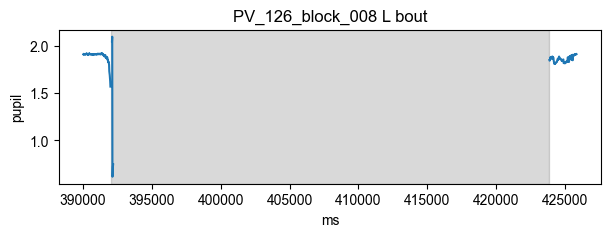

In [23]:
def show_bout(block_key, eye, row_idx):
    row = bouts_df.query("block==@block_key and eye==@eye").iloc[row_idx]
    print(row)
    block = block_dict[block_key]
    df = block.left_eye_data if eye=='L' else block.right_eye_data
    df = df if df is not None else (block.left_eye_data_clean if eye=='L' else block.right_eye_data_clean)
    sel = (df['ms_axis']>=row.start_ms-2000) & (df['ms_axis']<=row.end_ms+2000)
    ax = df.loc[sel, ['ms_axis','pupil_diameter']].plot(x='ms_axis', y='pupil_diameter', figsize=(7,2), legend=False)
    ax.axvspan(row.start_ms, row.end_ms, color='k', alpha=0.15)
    ax.set_xlabel('ms'); ax.set_ylabel('pupil'); ax.set_title(f"{block_key} {eye} bout")
show_bout('PV_126_block_008','L',0)
